# Code for model estimation

In [46]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder

In [7]:
from sklearn.metrics import precision_recall_fscore_support
# precision_recall_fscore_support(df_val['true_value'], df_val['pred_value'], average='weighted')

In [8]:
import seaborn as sn

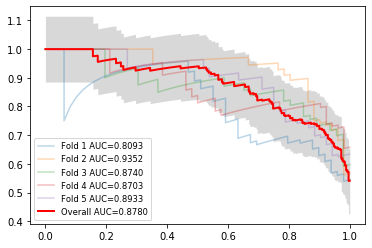

In [9]:
# https://stackoverflow.com/questions/55541254/precision-recall-curve-with-n-fold-cross-validation-showing-standard-deviation

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from numpy import interp
from sklearn.metrics import auc

X, y = make_blobs(n_samples=500, n_features=2, centers=2, cluster_std=10.0,
    random_state=10)

k_fold = KFold(n_splits=5, shuffle=True, random_state=10)
predictor = SVC(kernel='linear', C=1.0, probability=True, random_state=10)

y_real = []
y_proba = []

precision_array = []
threshold_array=[]
recall_array = np.linspace(0, 1, 100)

for i, (train_index, test_index) in enumerate(k_fold.split(X)):
    Xtrain, Xtest = X[train_index], X[test_index]
    ytrain, ytest = y[train_index], y[test_index]
    predictor.fit(Xtrain, ytrain)
    pred_proba = predictor.predict_proba(Xtest)
    precision_fold, recall_fold, thresh = precision_recall_curve(ytest, pred_proba[:,1])
    precision_fold, recall_fold, thresh = precision_fold[::-1], recall_fold[::-1], thresh[::-1]  # reverse order of results
    thresh = np.insert(thresh, 0, 1.0)
    precision_array = interp(recall_array, recall_fold, precision_fold)
    threshold_array = interp(recall_array, recall_fold, thresh)
    pr_auc = auc(recall_array, precision_array)

    lab_fold = 'Fold %d AUC=%.4f' % (i+1, pr_auc)
    plt.plot(recall_fold, precision_fold, alpha=0.3, label=lab_fold)
    y_real.append(ytest)
    y_proba.append(pred_proba[:,1])

y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)
precision, recall, _ = precision_recall_curve(y_real, y_proba)
lab = 'Overall AUC=%.4f' % (auc(recall, precision))

plt.plot(recall, precision, lw=2,color='red', label=lab)

plt.legend(loc='lower left', fontsize='small')

mean_precision = np.mean(precision_array)
std_precision = np.std(precision_array)
plt.fill_between(recall, precision + std_precision, precision - std_precision, alpha=0.3, linewidth=0, color='grey')
plt.show()

# Metrics calculation

In [10]:
from sklearn.metrics import roc_auc_score

class MultiClassMetrics():
    def __init__(self, y_true, y_pred):
        self.y_true = y_true
        self.y_pred = y_pred
        
    def calculate_scores(self, class_mapping_dict=None):
    
        y_true_ = self.y_true
        y_pred_ = self.y_pred
        if classes_map_dict is not None:
            y_true_ = y_true_.map(classes_map_dict)
            y_pred_ = y_pred_.map(classes_map_dict)
    
        self.cnf_matrix = confusion_matrix(y_true_, y_pred_)
        self.FP = self.cnf_matrix.sum(axis=0) - np.diag(self.cnf_matrix) 
        self.FN = self.cnf_matrix.sum(axis=1) - np.diag(self.cnf_matrix)
        self.TP = np.diag(self.cnf_matrix)
        self.TN = self.cnf_matrix.sum() - (self.FP + self.FN + self.TP)
        self.FP = self.FP.astype(float)
        self.FN = self.FN.astype(float)
        self.TP = self.TP.astype(float)
        self.TN = self.TN.astype(float)
        # Sensitivity, hit rate, recall, or true positive rate
        self.TPR = self.TP/(self.TP+self.FN)
        # Specificity or true negative rate
        self.TNR = self.TN/(self.TN+self.FP) 
        # Precision or positive predictive value
        self.PPV = self.TP/(self.TP+self.FP)
        # Negative predictive value
        self.NPV = self.TN/(self.TN+self.FN)
        # Fall out or false positive rate
        self.FPR = self.FP/(self.FP+self.TN)
        # False negative rate
        self.FNR = self.FN/(self.TP+self.FN)
        # False discovery rate
        self.FDR = self.FP/(self.TP+self.FP)
        # Overall accuracy for each class
        self.ACC = (self.TP+self.TN)/(self.TP+self.FP+self.FN+self.TN)

        self.F1_micro = f1_score(y_true_, y_pred_, average='micro')
        self.F1_macro = f1_score(y_true_, y_pred_, average='macro')
        self.F1_weighted = f1_score(y_true_, y_pred_, average='weighted')
        
#         self.AUC = auc(y_true_, y_pred_)

class MultiClassFoldsMetrics():
    def __init__(self, multi_class_metrics_list):
        self.multi_class_metrics_list = multi_class_metrics_list
        
    def calc_scores(self, class_mapping_dict=None, classes_n=None):
#         classes_n = self.multi_class_metrics_list[0].y_true.unique().shape[0]
        folds_n = len(self.multi_class_metrics_list)
        
        self.classes_n = classes_n
        self.folds_n = folds_n
        
        self.TPR_arr = np.zeros((folds_n, classes_n))
        self.TNR_arr = np.zeros((folds_n, classes_n))
        self.PPV_arr = np.zeros((folds_n, classes_n))
        self.NPV_arr = np.zeros((folds_n, classes_n))
        self.FPR_arr = np.zeros((folds_n, classes_n))
        self.FNR_arr = np.zeros((folds_n, classes_n))
        self.FDR_arr = np.zeros((folds_n, classes_n))
        self.ACC_arr = np.zeros((folds_n, classes_n))
        self.F1_micro_arr = np.zeros((folds_n))
        self.F1_macro_arr = np.zeros((folds_n))
        self.F1_weighted_arr = np.zeros((folds_n))
        self.cnf_matrix_arr = np.zeros((classes_n, classes_n))
#         self.AUC_arr = np.zeros((folds_n, classes_n))
        
        fold_n = 0
        for m in self.multi_class_metrics_list:
            m.calculate_scores(class_mapping_dict)

            self.TPR_arr[fold_n,:]=m.TPR
            self.TNR_arr[fold_n,:]=m.TNR
            self.PPV_arr[fold_n,:]=m.PPV
            self.NPV_arr[fold_n,:]=m.NPV
            self.FPR_arr[fold_n,:]=m.FPR
            self.FNR_arr[fold_n,:]=m.FNR
            self.FDR_arr[fold_n,:]=m.FDR
            self.ACC_arr[fold_n,:]=m.ACC
            self.F1_micro_arr[fold_n]=m.F1_micro
            self.F1_macro_arr[fold_n]=m.F1_macro
            self.F1_weighted_arr[fold_n]=m.F1_weighted
            self.cnf_matrix_arr = np.add(self.cnf_matrix_arr, m.cnf_matrix)
            
#             self.AUC_arr = m.AUC
            
            fold_n = fold_n + 1
            
    def print_scores(self):
        print('TPR={}, TNR={}, PPV={}, NPV={}, FPR={}, FNR={}, FDR={}, ACC={}, F1_micro={}, F1_macro={}, F1_weighted={}'.format(  #, AUC={}
                self.TPR_arr.mean(axis=0), 
                self.TNR_arr.mean(axis=0), 
                self.PPV_arr.mean(axis=0), 
                self.NPV_arr.mean(axis=0), 
                self.FPR_arr.mean(axis=0), 
                self.FNR_arr.mean(axis=0), 
                self.FDR_arr.mean(axis=0), 
                self.ACC_arr.mean(axis=0), 
                self.F1_micro_arr.mean(), 
                self.F1_macro_arr.mean(), 
                self.F1_weighted_arr.mean()  #,
#                 self.AUC_arr.mean(axis=0) 
                )
             )
        print('{}'.format(self.cnf_matrix_arr))
        
    def print_mean_classification_report(self, classes_map_dict=None, target_names=None):
        y_true_, y_pred_ = self.collect_ys(classes_map_dict)
        print(classification_report(y_true_, y_pred_, target_names=target_names))
        
    def collect_ys(self, classes_map_dict=None):
        y_true_ = pd.Series()
        y_pred_ = pd.Series()
        for m in self.multi_class_metrics_list:
            __y_tr = m.y_true.copy()
            __y_pr = m.y_pred.copy()
            
            if classes_map_dict is not None:
                __y_tr = __y_tr.map(classes_map_dict)
                __y_pr = __y_pr.map(classes_map_dict)
                
            y_true_ = y_true_.append(__y_tr, ignore_index=True, verify_integrity=False)
            y_pred_ = y_pred_.append(__y_pr, ignore_index=True, verify_integrity=False)
            
        return y_true_, y_pred_
        


In [11]:
def build_multi_class_metrics_list(val_file_template, layer, set_id, folds_n, classes_n):
    
    multi_class_metrics_list = []
    for fold_n in range(folds_n):
        file_path=val_file_template.format(layer, set_id, fold_n)
        df = pd.read_csv(file_path)
        
        true_value = df['true_value']
        pred_value = df['pred_value']
        
        multi_class_metric = MultiClassMetrics(true_value, pred_value)
        multi_class_metrics_list.append(multi_class_metric)
        
    return MultiClassFoldsMetrics(multi_class_metrics_list)

In [12]:
# val_file_template="/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_{}lrs_2oct_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_fold-{}/validation4_logits_predictions.csv"
# train_file_template="/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_{}lrs_2oct_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_fold-{}/train4_logits_predictions.csv"

val_file_template="/mnt/models/darts_retrained/4ch_128x128_12inchannel_no_metainfo_registered_5Fold_newC43_15Dec2020/XV2_SGD_orig_02DropChannel_{}lrs_15Dec_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_fold-{}/validation7ch_logits_predictions.csv"
train_file_template=     "/mnt/models/darts_retrained/4ch_128x128_12inchannel_no_metainfo_registered_5Fold_newC43_15Dec2020/XV2_SGD_orig_02DropChannel_{}lrs_15Dec_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_fold-{}/train7ch_logits_predictions.csv"



# ClassSet1

In [13]:
layers = [1,2,3,4,5]
sets = [1]

folds_n = 5
classes_n = 2

for l in layers:
    for set_id in sets:
        
        print('Layers-{}, Set-{}'.format(l, set_id))
        
        print('Validation:')
#         val_file_template = validation_file_path.format()
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/validation2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign'])
      
        
        print('--------------------------------')
        
        
        print('Training:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/train2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(train_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign'])
        
        print('--------------------------------')
        print('================================')
        print('--------------------------------')

Layers-1, Set-1
Validation:
TPR=[0.62344988 0.95520388], TNR=[0.95520388 0.62344988], PPV=[0.71391746 0.94030712], NPV=[0.94030712 0.71391746], FPR=[0.04479612 0.37655012], FNR=[0.37655012 0.04479612], FDR=[0.28608254 0.05969288], ACC=[0.90854609 0.90854609], F1_micro=0.9085460876106112, F1_macro=0.7992925888803171, F1_weighted=0.9061929732501082
[[ 41.  25.]
 [ 18. 387.]]
                       precision    recall  f1-score   support

Melanoma_like_lesions       0.69      0.62      0.66        66
     Pigmented_benign       0.94      0.96      0.95       405

             accuracy                           0.91       471
            macro avg       0.82      0.79      0.80       471
         weighted avg       0.91      0.91      0.91       471

--------------------------------
Training:
TPR=[0.83320437 0.99319055], TNR=[0.99319055 0.83320437], PPV=[0.95254041 0.97340558], NPV=[0.97340558 0.95254041], FPR=[0.00680945 0.16679563], FNR=[0.16679563 0.00680945], FDR=[0.04745959 0.02659442

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


TPR=[0.96915251 0.99876922], TNR=[0.99876922 0.96915251], PPV=[0.99252271 0.99509555], NPV=[0.99509555 0.99252271], FPR=[0.00123078 0.03084749], FNR=[0.03084749 0.00123078], FDR=[0.00747729 0.00490445], ACC=[0.99466935 0.99466935], F1_micro=0.9946693520730813, F1_macro=0.9885872630897176, F1_weighted=0.994605230250874
[[ 256.    8.]
 [   2. 1618.]]
                       precision    recall  f1-score   support

Melanoma_like_lesions       0.99      0.97      0.98       264
     Pigmented_benign       1.00      1.00      1.00      1620

             accuracy                           0.99      1884
            macro avg       0.99      0.98      0.99      1884
         weighted avg       0.99      0.99      0.99      1884

--------------------------------
--------------------------------
Layers-3, Set-1
Validation:
TPR=[0.56247086 0.9699004 ], TNR=[0.9699004  0.56247086], PPV=[0.79047619 0.93325291], NPV=[0.93325291 0.79047619], FPR=[0.0300996  0.43752914], FNR=[0.43752914 0.0300996 ], 

# 2 - layers is the best (looking at F1) 

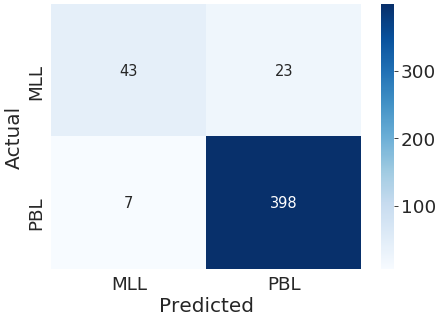

In [32]:
data = np.array([[ 43.,  23.],
                 [  7., 398.]])
if False:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['MLL', 'PBL'], index = ['MLL', 'PBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=2.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 21}, fmt='g')# font size

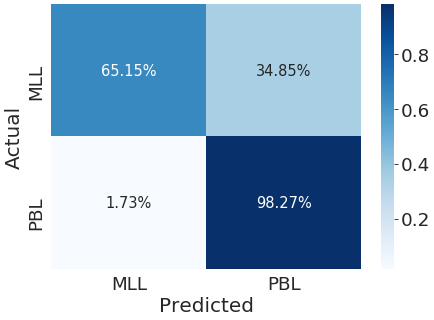

In [31]:
data = np.array([[ 43.,  23.],
                 [  7., 398.]])
if True:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['MLL', 'PBL'], index = ['MLL', 'PBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=2.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 21}, fmt='.2%')# font size

# ClassSet3

In [48]:
layers = [1,2,3,4,5]
sets = [3]

folds_n = 5
classes_n = 4

for l in layers:
    for set_id in sets:
        
        print('Layers-{}, Set-{}'.format(l, set_id))
        
        print('Validation:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/validation2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer'])
          
        print('--------------------------------')    
        print('Melanoma-like lesions vs. all other:')
        classes_map_dict={0:0, 1:1, 2:1, 3:1}
#         classes_map_dict={0:1, 1:0, 2:0, 3:0}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL', 'PB+KL+NonMSC'])
        
        print('--------------------------------')    
        print('Melanoma-like lesions+non-melanoma skin cancers vs. pigmented benign lesions + keratin lesions:')
        classes_map_dict={0:0, 1:1, 2:1, 3:0}
#         classes_map_dict={0:1, 1:0, 2:0, 3:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+NonMSC', 'PB+KL'])
        
        print('--------------------------------')
        print('--------------------------------')
        print('--------------------------------')
        
        print('Training:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/train2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(train_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer'])
          
        print('--------------------------------')    
        print('Melanoma-like lesions vs. all other:')
        classes_map_dict={0:0, 1:1, 2:1, 3:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL', 'PB+KL+NonMSC'])
        
        print('--------------------------------')    
        print('Melanoma-like lesions+non-melanoma skin cancers vs. pigmented benign lesions + keratin lesions:')
        classes_map_dict={0:0, 1:1, 2:1, 3:0}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+NonMSC', 'PB+KL'])        
        print('--------------------------------')
        print('================================')
        print('--------------------------------')

Layers-1, Set-3
Validation:
TPR=[0.54857809 0.84653727 0.6292947  0.60207962], TNR=[0.97783377 0.79302215 0.87146861 0.92926139], PPV=[0.69861111 0.77792959 0.65185856 0.67880684], NPV=[0.96440366 0.86000566 0.86048023 0.90776032], FPR=[0.02216623 0.20697785 0.12853139 0.07073861], FNR=[0.45142191 0.15346273 0.3707053  0.39792038], FDR=[0.30138889 0.22207041 0.34814144 0.32119316], ACC=[0.94587822 0.81676072 0.80339415 0.86626854], F1_micro=0.7161508140255517, F1_macro=0.6691409779328008, F1_weighted=0.7114113270062303
[[ 36.  19.   4.   7.]
 [  5. 343.  38.  19.]
 [  5.  63. 155.  25.]
 [  8.  20.  40. 103.]]
                         precision    recall  f1-score   support

  Melanoma_like_lesions       0.67      0.55      0.60        66
       Pigmented_benign       0.77      0.85      0.81       405
        Keratin_lesions       0.65      0.62      0.64       248
Nonmelanoma_skin_cancer       0.67      0.60      0.63       171

               accuracy                           0.72 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


TPR=[0.77279472 0.93895143 0.82813396 0.82724473], TNR=[0.989969   0.89086464 0.9525621  0.97188817], PPV=[0.86117182 0.87955212 0.8730581  0.87515039], NPV=[0.98196086 0.94663994 0.93538327 0.95955201], FPR=[0.010031   0.10913536 0.0474379  0.02811183], FNR=[0.22720528 0.06104857 0.17186604 0.17275527], FDR=[0.13882818 0.12044788 0.1269419  0.12484961], ACC=[0.9738665  0.91285267 0.91796065 0.94408878], F1_micro=0.8743843017414321, F1_macro=0.8550112043385362, F1_weighted=0.8731548809016498
[[ 204.   41.    9.   10.]
 [  13. 1521.   62.   24.]
 [   5.  118.  822.   47.]
 [  15.   52.   51.  566.]]
                         precision    recall  f1-score   support

  Melanoma_like_lesions       0.86      0.77      0.81       264
       Pigmented_benign       0.88      0.94      0.91      1620
        Keratin_lesions       0.87      0.83      0.85       992
Nonmelanoma_skin_cancer       0.87      0.83      0.85       684

               accuracy                           0.87      3560
  

TPR=[0.93174215 0.97717706 0.94356266 0.93566745], TNR=[0.99179456 0.97625052 0.98249932 0.98714873], PPV=[0.90234541 0.97211503 0.95495261 0.94571148], NPV=[0.99452439 0.98104245 0.97844211 0.98475591], FPR=[0.00820544 0.02374948 0.01750068 0.01285127], FNR=[0.06825785 0.02282294 0.05643734 0.06433255], FDR=[0.09765459 0.02788497 0.04504739 0.05428852], ACC=[0.98734441 0.97669366 0.97164792 0.97724092], F1_micro=0.956463454298001, F1_macro=0.9449938288141972, F1_weighted=0.9564600102177533
[[ 246.   11.    4.    3.]
 [   9. 1583.   20.    8.]
 [   3.   27.  936.   26.]
 [  15.    8.   21.  640.]]
                         precision    recall  f1-score   support

  Melanoma_like_lesions       0.90      0.93      0.92       264
       Pigmented_benign       0.97      0.98      0.97      1620
        Keratin_lesions       0.95      0.94      0.95       992
Nonmelanoma_skin_cancer       0.95      0.94      0.94       684

               accuracy                           0.96      3560
   

              precision    recall  f1-score   support

  MLL+NonMSC       0.76      0.72      0.74       237
       PB+KL       0.90      0.92      0.91       653

    accuracy                           0.87       890
   macro avg       0.83      0.82      0.82       890
weighted avg       0.86      0.87      0.86       890

--------------------------------
--------------------------------
--------------------------------
Training:
TPR=[0.96943202 0.98458464 0.96265789 0.95469939], TNR=[0.99303125 0.98912551 0.98908992 0.98993096], PPV=[0.91877006 0.9870514  0.97165181 0.95795626], NPV=[0.99755572 0.98721675 0.9856809  0.98925072], FPR=[0.00696875 0.01087449 0.01091008 0.01006904], FNR=[0.03056798 0.01541536 0.03734211 0.04530061], FDR=[0.08122994 0.0129486  0.02834819 0.04204374], ACC=[0.99129169 0.98707438 0.98172538 0.98315081], F1_micro=0.9716211250706579, F1_macro=0.9629668647245838, F1_weighted=0.9716767404126291
[[2.560e+02 5.000e+00 2.000e+00 1.000e+00]
 [8.000e+00 1.595e+03 1.

### 2 - layers give best for F1

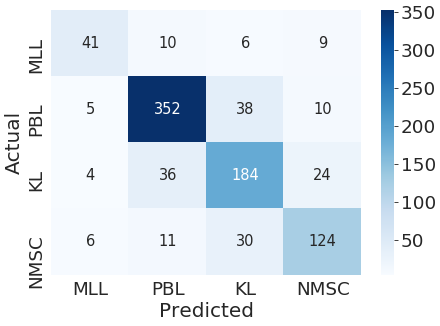

In [58]:
# data = np.array([[ 53.,   8.,   1.,   4.],
#                  [ 11., 352.,  33.,  10.],
#                  [  3.,  32., 182.,  31.],
#                  [  9.,  15.,  32., 115.]])

data = np.array([[ 41.,  10.,   6.,   9.],
                 [  5., 352.,  38.,  10.],
                 [  4.,  36., 184.,  24.],
                 [  6.,  11.,  30., 124.]])

if False:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['MLL', 'PBL', 'KL', 'NMSC'], index = ['MLL', 'PBL', 'KL', 'NMSC'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=2.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 21}, fmt='g')# font size

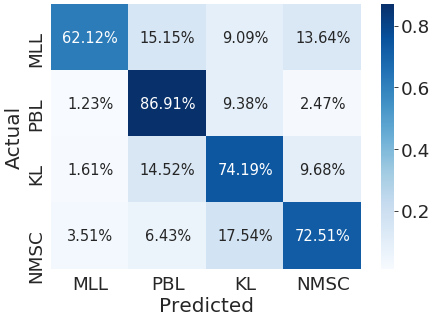

In [57]:
data = np.array([[ 41.,  10.,   6.,   9.],
                 [  5., 352.,  38.,  10.],
                 [  4.,  36., 184.,  24.],
                 [  6.,  11.,  30., 124.]])
if True:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['MLL', 'PBL', 'KL', 'NMSC'], index = ['MLL', 'PBL', 'KL', 'NMSC'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=2.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 21}, fmt='.2%')# font size

## 4 klasēm: skin cancer (MLL+NonMSC) vs. benign lesions (PBL+KL) 

In [52]:
layers = [1,2,3,4,5]
sets = [3]

folds_n = 5
classes_n = 5

for l in layers:
    for set_id in sets:
        
        print('Layers-{}, Set-{}'.format(l, set_id))
        
        print('Validation:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/validation2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
        
#         classes_map_dict = None
#         multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
#         multi_class_folds_metrics.print_scores()
#         multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer', 'Other'])
          
#         multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
    
        print('--------------------------------')    
#         print('NonMSC vs MLL+PB+KL+Other:')
        print('MLL+NonMSC vs PB+KL:')
        classes_map_dict={0:0, 1:1, 2:0, 3:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+NonMSC', 'PB+KL'])
        
        
        print('--------------------------------')
        print('--------------------------------')
        print('--------------------------------')
        
        print('Training:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/train2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(train_file_template, l, set_id, folds_n, classes_n)
        
#         classes_map_dict = None
#         multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
#         multi_class_folds_metrics.print_scores()
#         multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer', 'Other'])
        
        print('--------------------------------')    
#         print('NonMSC vs MLL+PB+KL+Other:')1aw2
        print('MLL+NonMSC vs PB+KL:')
        classes_map_dict={0:0, 1:1, 2:0, 3:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+NonMSC', 'PB+KL'])
        print('--------------------------------')
        print('================================')
        print('--------------------------------')


Layers-1, Set-3
Validation:
--------------------------------
MLL+NonMSC vs PB+KL:
TPR=[0.64175824 0.84127317], TNR=[0.84127317 0.64175824], PPV=[0.68760342 0.81371642], NPV=[0.81371642 0.68760342], FPR=[0.15872683 0.35824176], FNR=[0.35824176 0.15872683], FDR=[0.31239658 0.18628358], ACC=[0.76995764 0.76995764], F1_micro=0.7699576419413948, F1_macro=0.7424980011527754, F1_weighted=0.7669104672616566
[[200. 114.]
 [ 91. 485.]]
              precision    recall  f1-score   support

  MLL+NonMSC       0.69      0.64      0.66       314
       PB+KL       0.81      0.84      0.83       576

    accuracy                           0.77       890
   macro avg       0.75      0.74      0.74       890
weighted avg       0.77      0.77      0.77       890

--------------------------------
--------------------------------
--------------------------------
Training:
--------------------------------
MLL+NonMSC vs PB+KL:
TPR=[0.82761168 0.93883259], TNR=[0.93883259 0.82761168], PPV=[0.88170993 0.9096

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


TPR=[0.75076923 0.86271837], TNR=[0.86271837 0.75076923], PPV=[0.75034851 0.86408766], NPV=[0.86408766 0.75034851], FPR=[0.13728163 0.24923077], FNR=[0.24923077 0.13728163], FDR=[0.24965149 0.13591234], ACC=[0.82290295 0.82290295], F1_micro=0.8229029500047377, F1_macro=0.806103158874752, F1_weighted=0.8228600286609614
[[235.  79.]
 [ 79. 497.]]
              precision    recall  f1-score   support

  MLL+NonMSC       0.75      0.75      0.75       314
       PB+KL       0.86      0.86      0.86       576

    accuracy                           0.82       890
   macro avg       0.81      0.81      0.81       890
weighted avg       0.82      0.82      0.82       890

--------------------------------
--------------------------------
--------------------------------
Training:
--------------------------------
MLL+NonMSC vs PB+KL:
TPR=[0.98087497 0.9887255 ], TNR=[0.9887255  0.98087497], PPV=[0.9794494  0.98960586], NPV=[0.98960586 0.9794494 ], FPR=[0.0112745  0.01912503], FNR=[0.01912503 0.

# ClassSet4

In [20]:
layers = [1,2,3,4,5]
sets = [4]

folds_n = 5
classes_n = 2

for l in layers:
    for set_id in sets:
        
        print('Layers-{}, Set-{}'.format(l, set_id))
        
        print('Validation:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/validation2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['C43', 'D22'])
          
        print('--------------------------------')
        print('--------------------------------')
        print('--------------------------------')
        
        print('Training:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/train2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(train_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['C43', 'D22'])
              
        print('--------------------------------')
        print('================================')
        print('--------------------------------')

Layers-1, Set-4
Validation:
TPR=[0.64297369 0.95676485], TNR=[0.95676485 0.64297369], PPV=[0.71075092 0.9451582 ], NPV=[0.9451582  0.71075092], FPR=[0.04323515 0.35702631], FNR=[0.35702631 0.04323515], FDR=[0.28924908 0.0548418 ], ACC=[0.91430408 0.91430408], F1_micro=0.9143040772130565, F1_macro=0.8091481487559913, F1_weighted=0.9126475138994892
[[ 40.  22.]
 [ 17. 377.]]
              precision    recall  f1-score   support

         C43       0.70      0.65      0.67        62
         D22       0.94      0.96      0.95       394

    accuracy                           0.91       456
   macro avg       0.82      0.80      0.81       456
weighted avg       0.91      0.91      0.91       456

--------------------------------
--------------------------------
--------------------------------
Training:
TPR=[0.89922569 0.99302591], TNR=[0.99302591 0.89922569], PPV=[0.95357495 0.98429234], NPV=[0.98429234 0.95357495], FPR=[0.00697409 0.10077431], FNR=[0.10077431 0.00697409], FDR=[0.0464250

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


TPR=[0.99591837 0.99873217], TNR=[0.99873217 0.99591837], PPV=[0.99215686 0.99936709], NPV=[0.99936709 0.99215686], FPR=[0.00126783 0.00408163], FNR=[0.00408163 0.00126783], FDR=[0.00784314 0.00063291], ACC=[0.99835616 0.99835616], F1_micro=0.9983561561576384, F1_macro=0.9965129344224462, F1_weighted=0.9983583085374942
[[2.470e+02 1.000e+00]
 [2.000e+00 1.574e+03]]
              precision    recall  f1-score   support

         C43       0.99      1.00      0.99       248
         D22       1.00      1.00      1.00      1576

    accuracy                           1.00      1824
   macro avg       1.00      1.00      1.00      1824
weighted avg       1.00      1.00      1.00      1824

--------------------------------
--------------------------------
Layers-3, Set-4
Validation:
TPR=[0.73171828 0.98221276], TNR=[0.98221276 0.73171828], PPV=[0.8815873  0.95875198], NPV=[0.95875198 0.8815873 ], FPR=[0.01778724 0.26828172], FNR=[0.26828172 0.01778724], FDR=[0.1184127  0.04124802], ACC=[0.9

### 3- layers give best F1 for MLL class

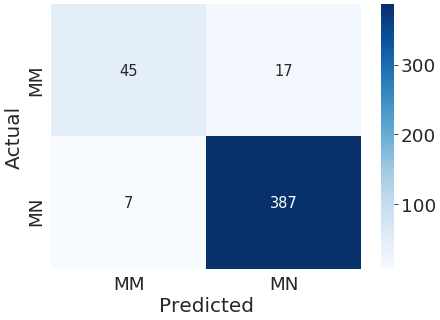

In [35]:
# data = np.array([[ 51.,  11.],
#                  [ 12., 380.]])

data = np.array([[ 45.,  17.],
                 [  7., 387.]])

if False: 
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
# df_cm = pd.DataFrame(data, columns=['C43', 'D22'], index = ['C43', 'D22'])
df_cm = pd.DataFrame(data, columns=['MM', 'MN'], index = ['MM', 'MN'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=2.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 21}, fmt='g')# font size

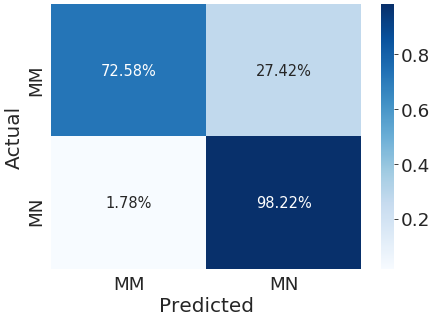

In [36]:
# data = np.array([[ 51.,  11.],
#                  [ 12., 380.]])

data = np.array([[ 45.,  17.],
                 [  7., 387.]])

if True:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]

# df_cm = pd.DataFrame(data, columns=['C43', 'D22'], index = ['C43', 'D22'])
df_cm = pd.DataFrame(data, columns=['MM', 'MN'], index = ['MM', 'MN'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=2.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 21}, fmt='.2%')# font size

# ClassSet8

In [23]:
layers = [1,2,3,4,5]
sets = [8]

folds_n = 5
classes_n = 5

for l in layers:
    for set_id in sets:
        
        print('Layers-{}, Set-{}'.format(l, set_id))
        
        print('Validation:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/validation2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer', 'Other'])
          
        print('--------------------------------')    
        print('Melanoma-like lesions vs. all other:')
        classes_map_dict={0:0, 1:1, 2:1, 3:1, 4:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL', 'PB+KL+NonMSC+Other'])
        
        print('--------------------------------')    
        print('Melanoma-like lesions+non-melanoma skin cancers vs. pigmented benign lesions + keratin lesions:')
        classes_map_dict={0:0, 1:1, 2:1, 3:0, 4:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+NonMSC', 'PB+KL+Other'])
        
        print('--------------------------------')
        print('--------------------------------')
        print('--------------------------------')
        
        print('Training:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/train2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(train_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer', 'Other'])
          
        print('--------------------------------')    
        print('Melanoma-like lesions vs. all other:')
        classes_map_dict={0:0, 1:1, 2:1, 3:1, 4:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL', 'PB+KL+NonMSC+Other'])
        
        print('--------------------------------')    
        print('Melanoma-like lesions+non-melanoma skin cancers vs. pigmented benign lesions + keratin lesions:')
        classes_map_dict={0:0, 1:1, 2:1, 3:0, 4:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+NonMSC', 'PB+KL+Other'])
        print('--------------------------------')
        print('================================')
        print('--------------------------------')


Layers-1, Set-8
Validation:
TPR=[0.56675991 0.78489583 0.53494788 0.48585859 0.72864864], TNR=[0.989589   0.863478   0.93851807 0.95958454 0.78899405], PPV=[0.74195527 0.7016498  0.64960091 0.64348037 0.6666448 ], NPV=[0.97866026 0.90851468 0.90402086 0.93046928 0.8354239 ], FPR=[0.010411   0.136522   0.06148193 0.04041546 0.21100595], FNR=[0.43324009 0.21510417 0.46505212 0.51414141 0.27135136], FDR=[0.25804473 0.2983502  0.35039909 0.35651963 0.3333552 ], ACC=[0.96949882 0.84059974 0.86684963 0.90160705 0.76712155], F1_micro=0.6728383939691805, F1_macro=0.6403350628312131, F1_weighted=0.6669949615461059
[[ 37.  14.   3.   7.   5.]
 [  4. 318.  20.   5.  58.]
 [  1.  34. 132.  14.  67.]
 [  7.   9.  14.  83.  58.]
 [  2.  79.  34.  23. 370.]]
                         precision    recall  f1-score   support

  Melanoma_like_lesions       0.73      0.56      0.63        66
       Pigmented_benign       0.70      0.79      0.74       405
        Keratin_lesions       0.65      0.53      

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


              precision    recall  f1-score   support

  MLL+NonMSC       0.73      0.57      0.64       237
 PB+KL+Other       0.92      0.96      0.94      1161

    accuracy                           0.89      1398
   macro avg       0.82      0.76      0.79      1398
weighted avg       0.88      0.89      0.89      1398

--------------------------------
--------------------------------
--------------------------------
Training:
TPR=[0.71998898 0.89563127 0.72617845 0.67957944 0.84608919], TNR=[0.99306605 0.91413892 0.97068124 0.98128673 0.87587312], PPV=[0.8379143  0.81051636 0.84494342 0.8374716  0.79728197], NPV=[0.98621201 0.95556096 0.94288348 0.95651785 0.90920096], FPR=[0.00693395 0.08586108 0.02931876 0.01871327 0.12412688], FNR=[0.28001102 0.10436873 0.27382155 0.32042056 0.15391081], FDR=[0.1620857  0.18948364 0.15505658 0.1625284  0.20271803], ACC=[0.98016344 0.90876219 0.92736861 0.94435295 0.86503344], F1_micro=0.8128403124910555, F1_macro=0.7944621193987895, F1_weighte

TPR=[0.62699301 0.97539662], TNR=[0.97539662 0.62699301], PPV=[0.59219716 0.98130947], NPV=[0.98130947 0.59219716], FPR=[0.02460338 0.37300699], FNR=[0.37300699 0.02460338], FDR=[0.40780284 0.01869053], ACC=[0.95877158 0.95877158], F1_micro=0.9587715799919551, F1_macro=0.7844043532723932, F1_weighted=0.959944763804276
[[  41.   25.]
 [  33. 1299.]]
                    precision    recall  f1-score   support

               MLL       0.55      0.62      0.59        66
PB+KL+NonMSC+Other       0.98      0.98      0.98      1332

          accuracy                           0.96      1398
         macro avg       0.77      0.80      0.78      1398
      weighted avg       0.96      0.96      0.96      1398

--------------------------------
Melanoma-like lesions+non-melanoma skin cancers vs. pigmented benign lesions + keratin lesions:
TPR=[0.59948373 0.94966941], TNR=[0.94966941 0.59948373], PPV=[0.72753142 0.92142868], NPV=[0.92142868 0.72753142], FPR=[0.05033059 0.40051627], FNR=[0.40051

              precision    recall  f1-score   support

  MLL+NonMSC       0.94      0.94      0.94       948
 PB+KL+Other       0.99      0.99      0.99      4644

    accuracy                           0.98      5592
   macro avg       0.96      0.96      0.96      5592
weighted avg       0.98      0.98      0.98      5592

--------------------------------
--------------------------------
Layers-5, Set-8
Validation:
TPR=[0.6422311  0.7803458  0.61061615 0.51366607 0.74974938], TNR=[0.97451181 0.88286678 0.93642351 0.96739018 0.82407964], PPV=[0.56       0.73135761 0.67314391 0.69341737 0.70936114], NPV=[0.98202393 0.90778719 0.91791037 0.9345703  0.85224153], FPR=[0.02548819 0.11713322 0.06357649 0.03260982 0.17592036], FNR=[0.3577689  0.2196542  0.38938385 0.48633393 0.25025062], FDR=[0.44       0.26864239 0.32685609 0.30658263 0.29063886], ACC=[0.95872532 0.8530272  0.87854059 0.91168707 0.79699385], F1_micro=0.6994870145725642, F1_macro=0.6601153543018212, F1_weighted=0.69585305161

### 2 - layers have best F1(TPR) for clas MLL

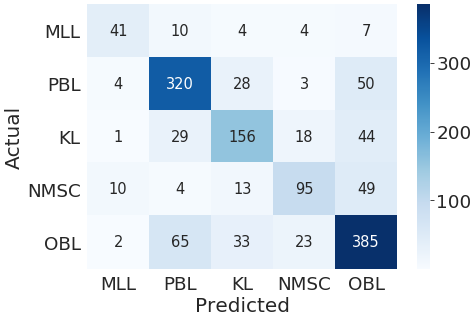

In [55]:
# data = np.array([[ 49.,   6.,   1.,   5.,   5.],
#                  [  4., 327.,  22.,   8.,  45.],
#                  [  0.,  27., 153.,  18.,  50.],
#                  [  6.,   3.,  14., 100.,  48.],
#                  [  4.,  62.,  33.,  33., 376.]])
data = np.array([[ 41.,  10.,   4.,   4.,   7.],
                 [  4., 320.,  28.,   3.,  50.],
                 [  1.,  29., 156.,  18.,  44.],
                 [ 10.,   4.,  13.,  95.,  49.],
                 [  2.,  65.,  33.,  23., 385.]])

if False:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['MLL', 'PBL', 'KL', 'NMSC', 'OBL'], index = ['MLL', 'PBL', 'KL', 'NMSC', 'OBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=2.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 21}, fmt='g')# font size .2%

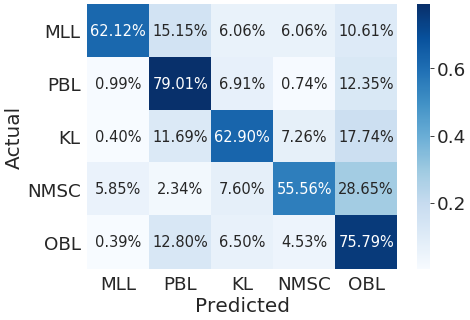

In [56]:
# data = np.array([[ 49.,   6.,   1.,   5.,   5.],
#                  [  4., 327.,  22.,   8.,  45.],
#                  [  0.,  27., 153.,  18.,  50.],
#                  [  6.,   3.,  14., 100.,  48.],
#                  [  4.,  62.,  33.,  33., 376.]])
data = np.array([[ 41.,  10.,   4.,   4.,   7.],
                 [  4., 320.,  28.,   3.,  50.],
                 [  1.,  29., 156.,  18.,  44.],
                 [ 10.,   4.,  13.,  95.,  49.],
                 [  2.,  65.,  33.,  23., 385.]])
if True:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['MLL', 'PBL', 'KL', 'NMSC', 'OBL'], index = ['MLL', 'PBL', 'KL', 'NMSC', 'OBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=2.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 21}, fmt='.2%')# font size .2%

## ClassSet8 - NonMSC vs rest

In [27]:
layers = [1,2,3,4,5]
sets = [8]

folds_n = 5
classes_n = 5

for l in layers:
    for set_id in sets:
        
        print('Layers-{}, Set-{}'.format(l, set_id))
        
        print('Validation:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/validation2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
        
#         classes_map_dict = None
#         multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
#         multi_class_folds_metrics.print_scores()
#         multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer', 'Other'])
          
#         multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
    
        print('--------------------------------')    
        print('NonMSC vs MLL+PB+KL+Other:')
        classes_map_dict={0:0, 1:0, 2:0, 3:1, 4:0}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+PB+KL+Other', 'NonMSC'])
        
        
        print('--------------------------------')
        print('--------------------------------')
        print('--------------------------------')
        
        print('Training:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/train2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(train_file_template, l, set_id, folds_n, classes_n)
        
#         classes_map_dict = None
#         multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
#         multi_class_folds_metrics.print_scores()
#         multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer', 'Other'])
        
        print('--------------------------------')    
        print('NonMSC vs MLL+PB+KL+Other:')
        classes_map_dict={0:0, 1:0, 2:0, 3:1, 4:0}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+PB+KL+Other', 'NonMSC'])
        print('--------------------------------')
        print('================================')
        print('--------------------------------')


Layers-1, Set-8
Validation:
--------------------------------
NonMSC vs MLL+PB+KL+Other:
TPR=[0.95958454 0.48585859], TNR=[0.48585859 0.95958454], PPV=[0.93046928 0.64348037], NPV=[0.64348037 0.93046928], FPR=[0.51414141 0.04041546], FNR=[0.04041546 0.51414141], FDR=[0.06953072 0.35651963], ACC=[0.90160705 0.90160705], F1_micro=0.9016070456986645, F1_macro=0.7467964810539743, F1_weighted=0.8962110417340682
[[1178.   49.]
 [  88.   83.]]
                 precision    recall  f1-score   support

MLL+PB+KL+Other       0.93      0.96      0.95      1227
         NonMSC       0.63      0.49      0.55       171

       accuracy                           0.90      1398
      macro avg       0.78      0.72      0.75      1398
   weighted avg       0.89      0.90      0.90      1398

--------------------------------
--------------------------------
--------------------------------
Training:
--------------------------------
NonMSC vs MLL+PB+KL+Other:
TPR=[0.98128673 0.67957944], TNR=[0.67957944 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


                 precision    recall  f1-score   support

MLL+PB+KL+Other       0.96      0.98      0.97      4908
         NonMSC       0.83      0.68      0.75       684

       accuracy                           0.94      5592
      macro avg       0.90      0.83      0.86      5592
   weighted avg       0.94      0.94      0.94      5592

--------------------------------
--------------------------------
Layers-2, Set-8
Validation:
--------------------------------
NonMSC vs MLL+PB+KL+Other:
TPR=[0.96097793 0.55733809], TNR=[0.55733809 0.96097793], PPV=[0.93990283 0.66679654], NPV=[0.66679654 0.93990283], FPR=[0.44266191 0.03902207], FNR=[0.03902207 0.44266191], FDR=[0.06009717 0.33320346], ACC=[0.91162447 0.91162447], F1_micro=0.9116244650759405, F1_macro=0.776334778734477, F1_weighted=0.9077107820330816
[[1179.   48.]
 [  76.   95.]]
                 precision    recall  f1-score   support

MLL+PB+KL+Other       0.94      0.96      0.95      1227
         NonMSC       0.66      0.5

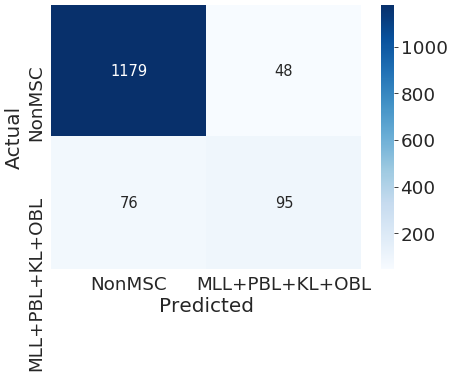

In [45]:
# data = np.array([[572.,  35.],
#                  [ 34.,  52.]])

# 2 -layers - best TPR
data = np.array([[1179.,   48.],
                 [  76.,   95.]])

if False:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['NonMSC', 'MLL+PBL+KL+OBL'], index = ['NonMSC', 'MLL+PBL+KL+OBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=2.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 21}, fmt='g')# font size .2%

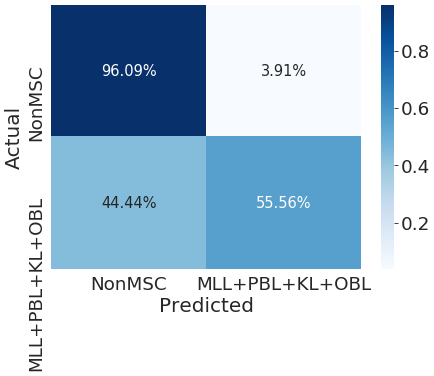

In [40]:
# data = np.array([[572.,  35.],
#                  [ 34.,  52.]])

# 2 -layers - best TPR
data = np.array([[1179.,   48.],
                 [  76.,   95.]])
if True:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['NonMSC', 'MLL+PBL+KL+OBL'], index = ['NonMSC', 'MLL+PBL+KL+OBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=2.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 21}, fmt='.2%')# font size .2%

## ClassSet8 (MLL+nonMSC) vs. benign lesions (PBL+KL+OBL)

In [54]:
layers = [1,2,3,4,5]
sets = [8]

folds_n = 5
classes_n = 5

for l in layers:
    for set_id in sets:
        
        print('Layers-{}, Set-{}'.format(l, set_id))
        
        print('Validation:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/validation2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
        
#         classes_map_dict = None
#         multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
#         multi_class_folds_metrics.print_scores()
#         multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer', 'Other'])
          
#         multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
    
        print('--------------------------------')    
        print('(MLL+nonMSC) vs. benign lesions (PBL+KL+OBL):')
        classes_map_dict={0:0, 1:1, 2:1, 3:0, 4:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+nonMSC', 'PBL+KL+OBL'])
        
        
        print('--------------------------------')
        print('--------------------------------')
        print('--------------------------------')
        
        print('Training:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/train2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(train_file_template, l, set_id, folds_n, classes_n)
        
#         classes_map_dict = None
#         multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
#         multi_class_folds_metrics.print_scores()
#         multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer', 'Other'])
        
        print('--------------------------------')    
        print('(MLL+nonMSC) vs. benign lesions (PBL+KL+OBL):')
        classes_map_dict={0:0, 1:1, 2:1, 3:0, 4:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+nonMSC', 'PBL+KL+OBL'])
        print('--------------------------------')
        print('================================')
        print('--------------------------------')


Layers-1, Set-8
Validation:
--------------------------------
(MLL+nonMSC) vs. benign lesions (PBL+KL+OBL):
TPR=[0.56646424 0.95745958], TNR=[0.95745958 0.56646424], PPV=[0.73709478 0.91544271], NPV=[0.91544271 0.73709478], FPR=[0.04254042 0.43353576], FNR=[0.43353576 0.04254042], FDR=[0.26290522 0.08455729], ACC=[0.89112782 0.89112782], F1_micro=0.8911278163451529, F1_macro=0.7871197618033384, F1_weighted=0.8854564825603329
[[ 134.  103.]
 [  49. 1112.]]
              precision    recall  f1-score   support

  MLL+nonMSC       0.73      0.57      0.64       237
  PBL+KL+OBL       0.92      0.96      0.94      1161

    accuracy                           0.89      1398
   macro avg       0.82      0.76      0.79      1398
weighted avg       0.88      0.89      0.89      1398

--------------------------------
--------------------------------
--------------------------------
Training:
--------------------------------
(MLL+nonMSC) vs. benign lesions (PBL+KL+OBL):
TPR=[0.72016022 0.97829414

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


              precision    recall  f1-score   support

  MLL+nonMSC       0.87      0.72      0.79       948
  PBL+KL+OBL       0.94      0.98      0.96      4644

    accuracy                           0.93      5592
   macro avg       0.91      0.85      0.87      5592
weighted avg       0.93      0.93      0.93      5592

--------------------------------
--------------------------------
Layers-2, Set-8
Validation:
--------------------------------
(MLL+nonMSC) vs. benign lesions (PBL+KL+OBL):
TPR=[0.63484422 0.95631068], TNR=[0.95631068 0.63484422], PPV=[0.74971997 0.92783036], NPV=[0.92783036 0.74971997], FPR=[0.04368932 0.36515578], FNR=[0.36515578 0.04368932], FDR=[0.25028003 0.07216964], ACC=[0.90177976 0.90177976], F1_micro=0.9017797575655916, F1_macro=0.8136117778552313, F1_weighted=0.8983276326343154
[[ 150.   87.]
 [  51. 1110.]]
              precision    recall  f1-score   support

  MLL+nonMSC       0.75      0.63      0.68       237
  PBL+KL+OBL       0.93      0.96      